In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action = 'ignore')

In [ ]:
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


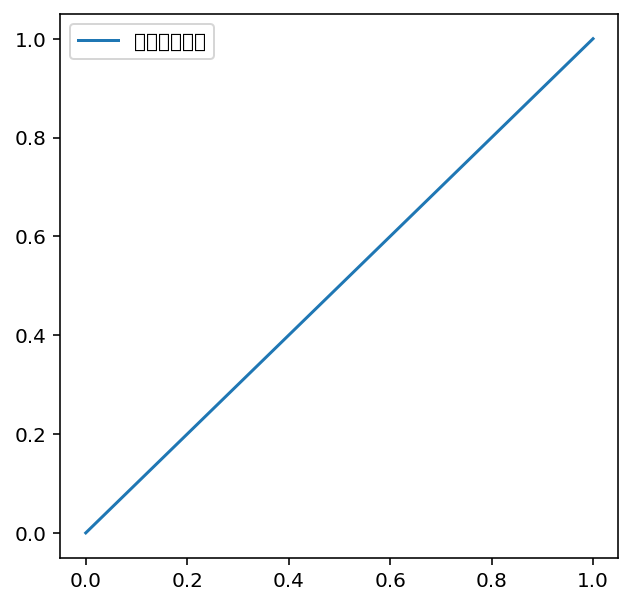

In [ ]:
plt.figure(figsize=(5,5))
plt.plot([0,1], [0,1], label='한글테스트용')
plt.legend()
plt.show()

# Kaggle 필사 1탄
code by
https://www.kaggle.com/vikassingh1996/riiid-eda-fe-and-feature-importance

학생들이 미래의 상호작용에 대해 어떻게 수행할지 예측하는 것이 이번 Competition의 문제!

## 1. train.csv

In [ ]:
train=pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/Kaggle_data/Riiid/train.csv',
                  low_memory=False, 
                  nrows=10**6, 
                  dtype={
                      'row_id': 'int64', 
                      'timestamp': 'int64', 
                      'user_id': 'int32', 
                      'content_id': 'int16', 
                      'content_type_id': 'int8',
                      'task_container_id': 'int16', 
                      'user_answer': 'int8', 
                      'answered_correctly': 'int8', 
                      'prior_question_elapsed_time': 'float32', 
                      'prior_question_had_explanation': 'boolean'
                    }
                  )

questions = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/Kaggle_data/Riiid/questions.csv')
lectures = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/Kaggle_data/Riiid/lectures.csv')

In [ ]:
def description(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Second Value'] = df.iloc[1].values
    summary['Third Value'] = df.iloc[2].values
    return summary

In [ ]:
description(train)

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,row_id,int64,0,1000000,0,1,2
1,timestamp,int64,0,769357,0,56943,118363
2,user_id,int32,0,3824,115,115,115
3,content_id,int16,0,13320,5692,5716,128
4,content_type_id,int8,0,2,0,0,0
5,task_container_id,int16,0,7740,1,2,0
6,user_answer,int8,0,5,3,2,0
7,answered_correctly,int8,0,3,1,1,1
8,prior_question_elapsed_time,float32,23723,1659,NaN,37000,55000
9,prior_question_had_explanation,boolean,3816,2,<NA>,False,False


In [ ]:
train.describe()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time
count,1000000.000000,1.000000e+06,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,976277.000000
mean,499999.500000,7.344311e+09,1.017255e+07,5232.691523,0.019907,806.105689,1.374784,0.617504,25319.472656
std,288675.278933,1.058693e+10,6.029234e+06,3882.323419,0.139681,1025.887530,1.194168,0.525364,19707.429688
min,0.000000,0.000000e+00,1.150000e+02,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000
25%,249999.750000,5.211669e+08,4.702585e+06,2057.000000,0.000000,109.000000,0.000000,0.000000,16000.000000
50%,499999.500000,2.824811e+09,9.678259e+06,5052.000000,0.000000,391.000000,1.000000,1.000000,21000.000000
75%,749999.250000,1.010186e+10,1.556872e+07,7421.000000,0.000000,1112.000000,3.000000,1.000000,29666.000000
max,999999.000000,7.809200e+10,2.094902e+07,32736.000000,1.000000,7739.000000,3.000000,1.000000,300000.000000


train.csv
- row_id:(int64) 행 번호
- timestamp:(int64) 사용자의 이벤트 사이의 기간
- user_id: (int32) USER ID
- content_id: (int16) User의 상호작용 ID
- content_type_id: (int8) 이벤트가 사용자에게 제기되는 질문인 경우 0, 사용자가 강의를 시청하는 경우 1
- task_container_id: (int16) 질문 또는 강의 일괄 처리를 위한 코드. 예를 들어, 사용자는 그 중 하나에 대한 설명을 보기 전에 세 개의 질문을 연속으로 볼 수 있다. 이들 셋은 모두 하나의 task_container_id를 공유할 것이다. 각 사용자마다 단조롭게 증가
- user_answer: (int8) User의 문제에 대한 답변, 답변을 안했으면 -1
- prior_question_elapsed_time: 중간 강의는 무시한채로, 사용자가 이전 질문 번들에 대답하는데 걸린 시간의 길이. 이 값은 단일 질문 번들에 걸쳐 공유되며, 사용자의 첫 번째 질문 번들 또는 강의에 대해서는 null이다. 시간은 사용자가 이전 번들의 모든 문제를 풀기 위해 걸린 총 시간이다.
- prior_question_had_explanation: (bool) 중간 강의는 무시한채로, 사용자가 이전 질문 번들에 답한 후 설명과 정확한 답변을 보았는지 여부. 일반적으로 사용자가 처음 보는 몇 가지 문제는 피드백을 받지 못하는 탑재형 진단 테스트의 일부였다.

questions.csv (사용자에게 제시된 질문에 대한 메타데이터)
- question_id: content_type이 0인 경우, train/test content_id의 외래 키
- bundle_id: 문제와 함께 제공되는 코드 -> 지문 느낌

lectures.csv
- lecture_id: content_id가 1인 경우, train/test content_id column의 외래 키
- part: 강의의 최상위 카테고리 코드
- tag: -
- type_of: 강의의 간략한 주제

# Train.csv

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


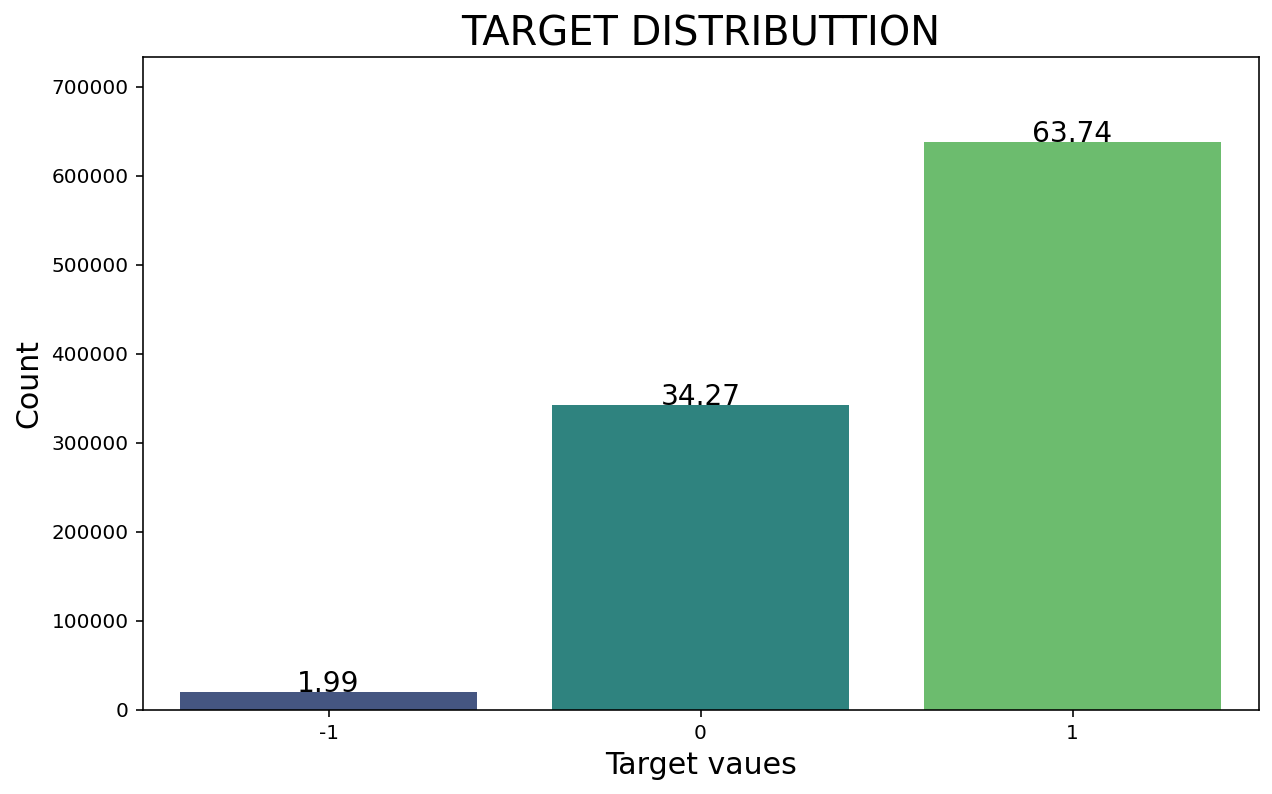

In [ ]:
total = len(train)
plt.figure(figsize=(10,6))

g = sns.countplot(x = 'answered_correctly',data=train,palette='viridis')
g.set_title('TARGET DISTRIBUTTION',fontsize = 20)
g.set_xlabel('Target vaues',fontsize = 15)
g.set_ylabel('Count',fontsize=15)
sizes = []
for p in g.patches:
  height = p.get_height()
  sizes.append(height)
  g.text(p.get_x() + p.get_width()/2.,
         height +3,
         '{:1.2f}'.format(height/total*100),
         ha = 'center', fontsize=14)
g.set_ylim(0,max(sizes)* 1.15)

plt.show()

사용자들은 평균적으로 64.33%로 정답을 맞춘다. -1은 null로, 강의의 경우 정답 분석을 위해 제외해야 한다.

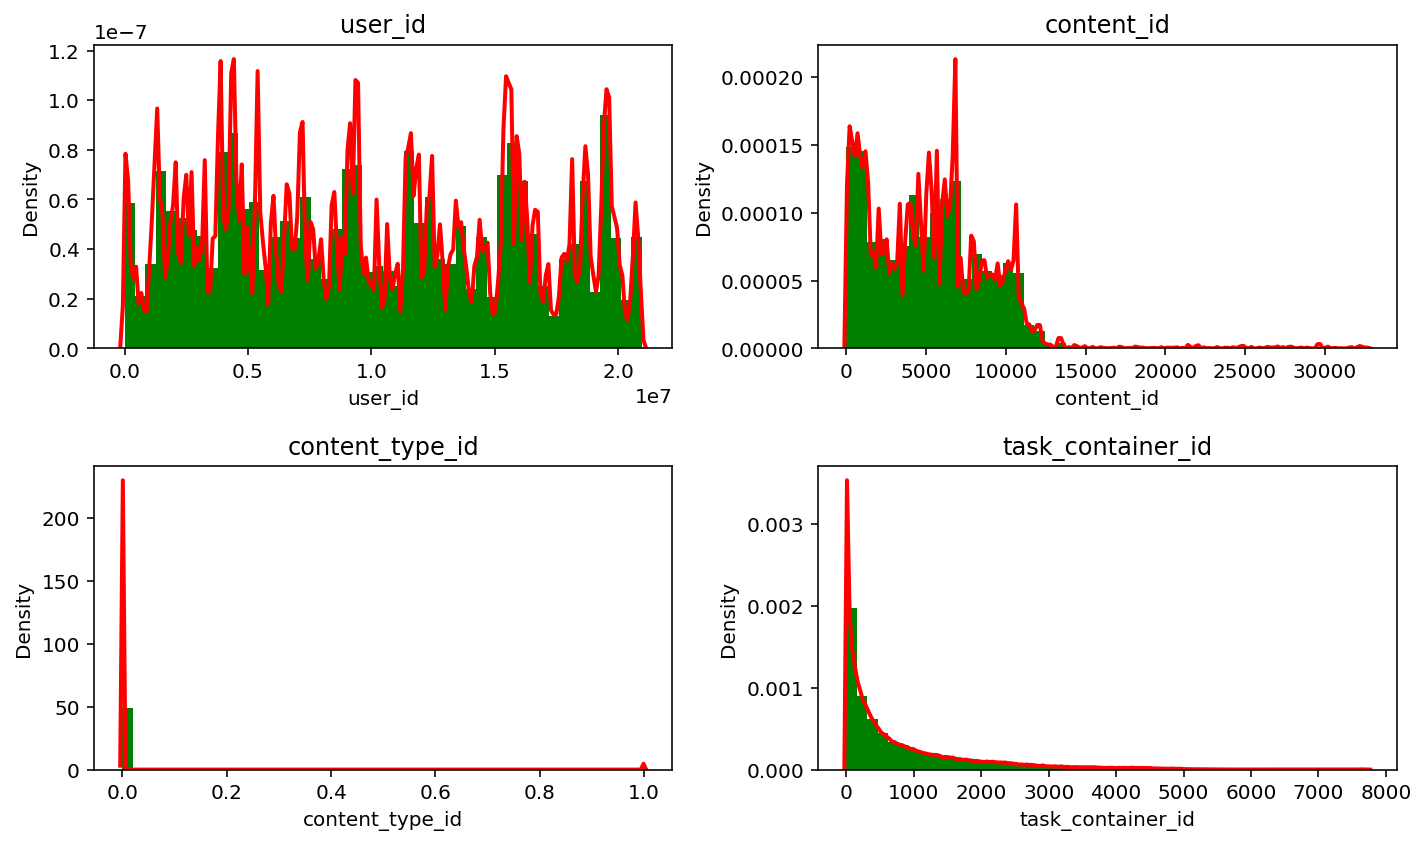

In [ ]:
id_col = ['user_id', 'content_id', 'content_type_id', 'task_container_id']
plt.figure(figsize=(10,6))
for i, col in enumerate(id_col):
    plt.subplot(2, 2, i + 1)
    sns.distplot(train[col], color='green', 
                 hist_kws={'alpha':1,"linewidth": 2},
                 kde_kws={"color": "red", "lw": 2, 'bw':0.01})
    plt.title(col)
    plt.tight_layout()

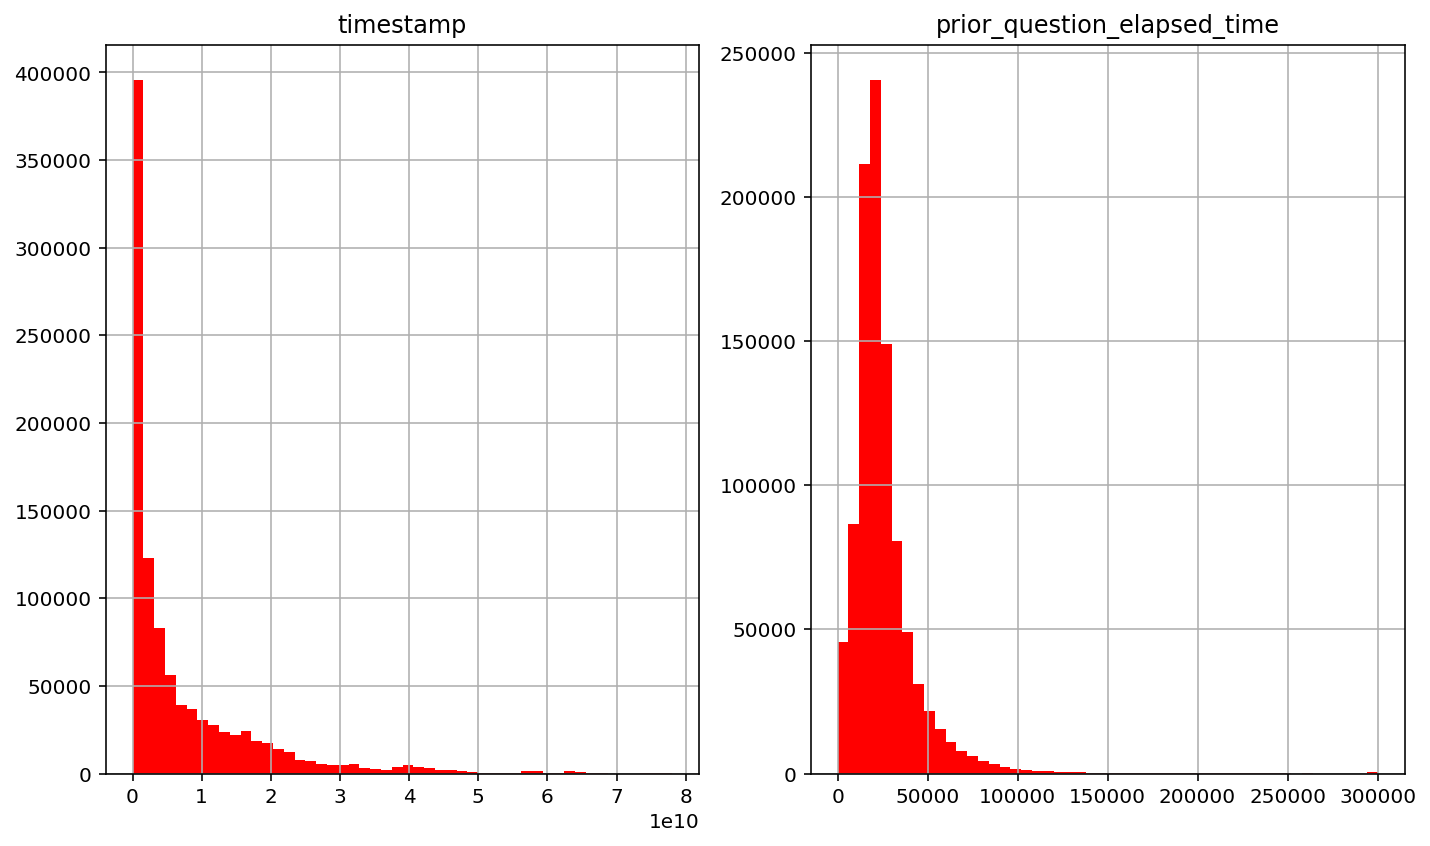

In [ ]:
time_col = ['timestamp', 'prior_question_elapsed_time']
plt.figure(figsize=(10,6))
for i, col in enumerate(time_col):
  plt.subplot(1,2,i+1)
  train[col].hist(bins = 50, color='red')
  plt.title(col)
  plt.tight_layout()

Timestamp 변수는 사용자의 첫 문제풀이 순간에서 현재 문제풀이 순간 사이의 시간이다. Prior question elapsed time 변수는 사용자가 그들의 이전 문제 번들을 푸는데 걸린 시간이다.

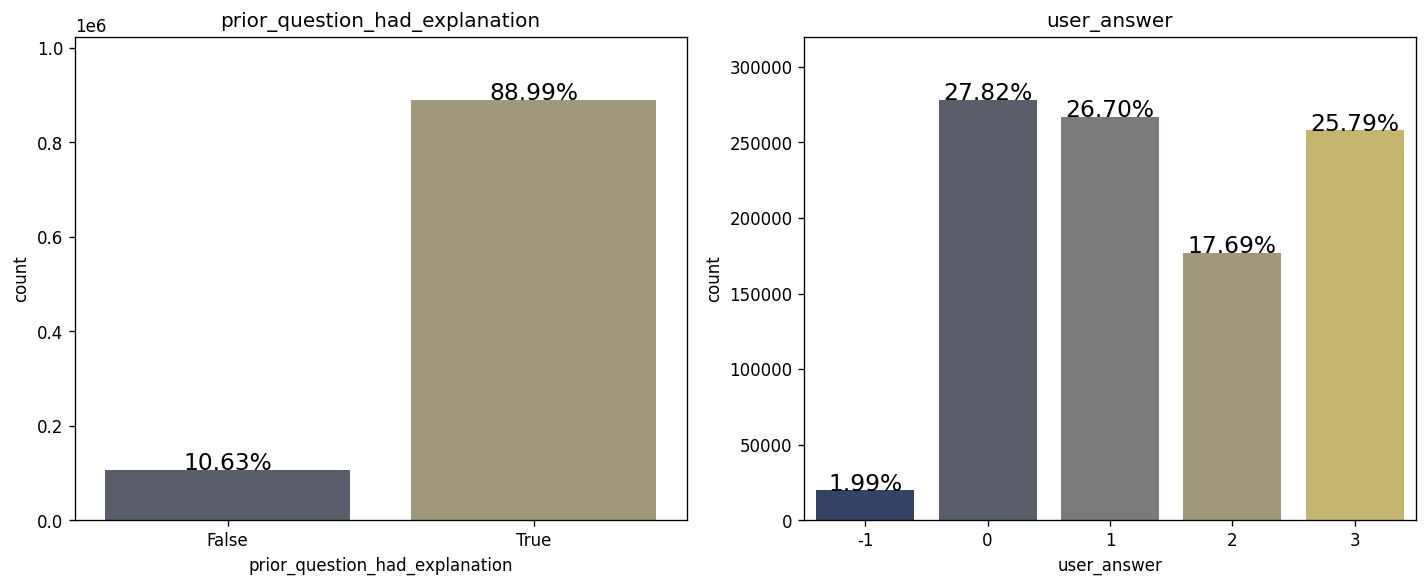

In [ ]:
col = ['prior_question_had_explanation','user_answer']

toal = len(train)
plt.figure(figsize = (12,5),dpi=60)
for i, col in enumerate(col):
  plt.subplot(1,2,i+1)
  g = sns.countplot(train[col].dropna(),palette='cividis')
  sizes = []
  for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
           height +3,
           '{:1.2f}%'.format(height/total*100),
           ha= 'center',fontsize=14)
    g.set_ylim(0,max(sizes)*1.15)
    plt.title(col)
    plt.tight_layout()

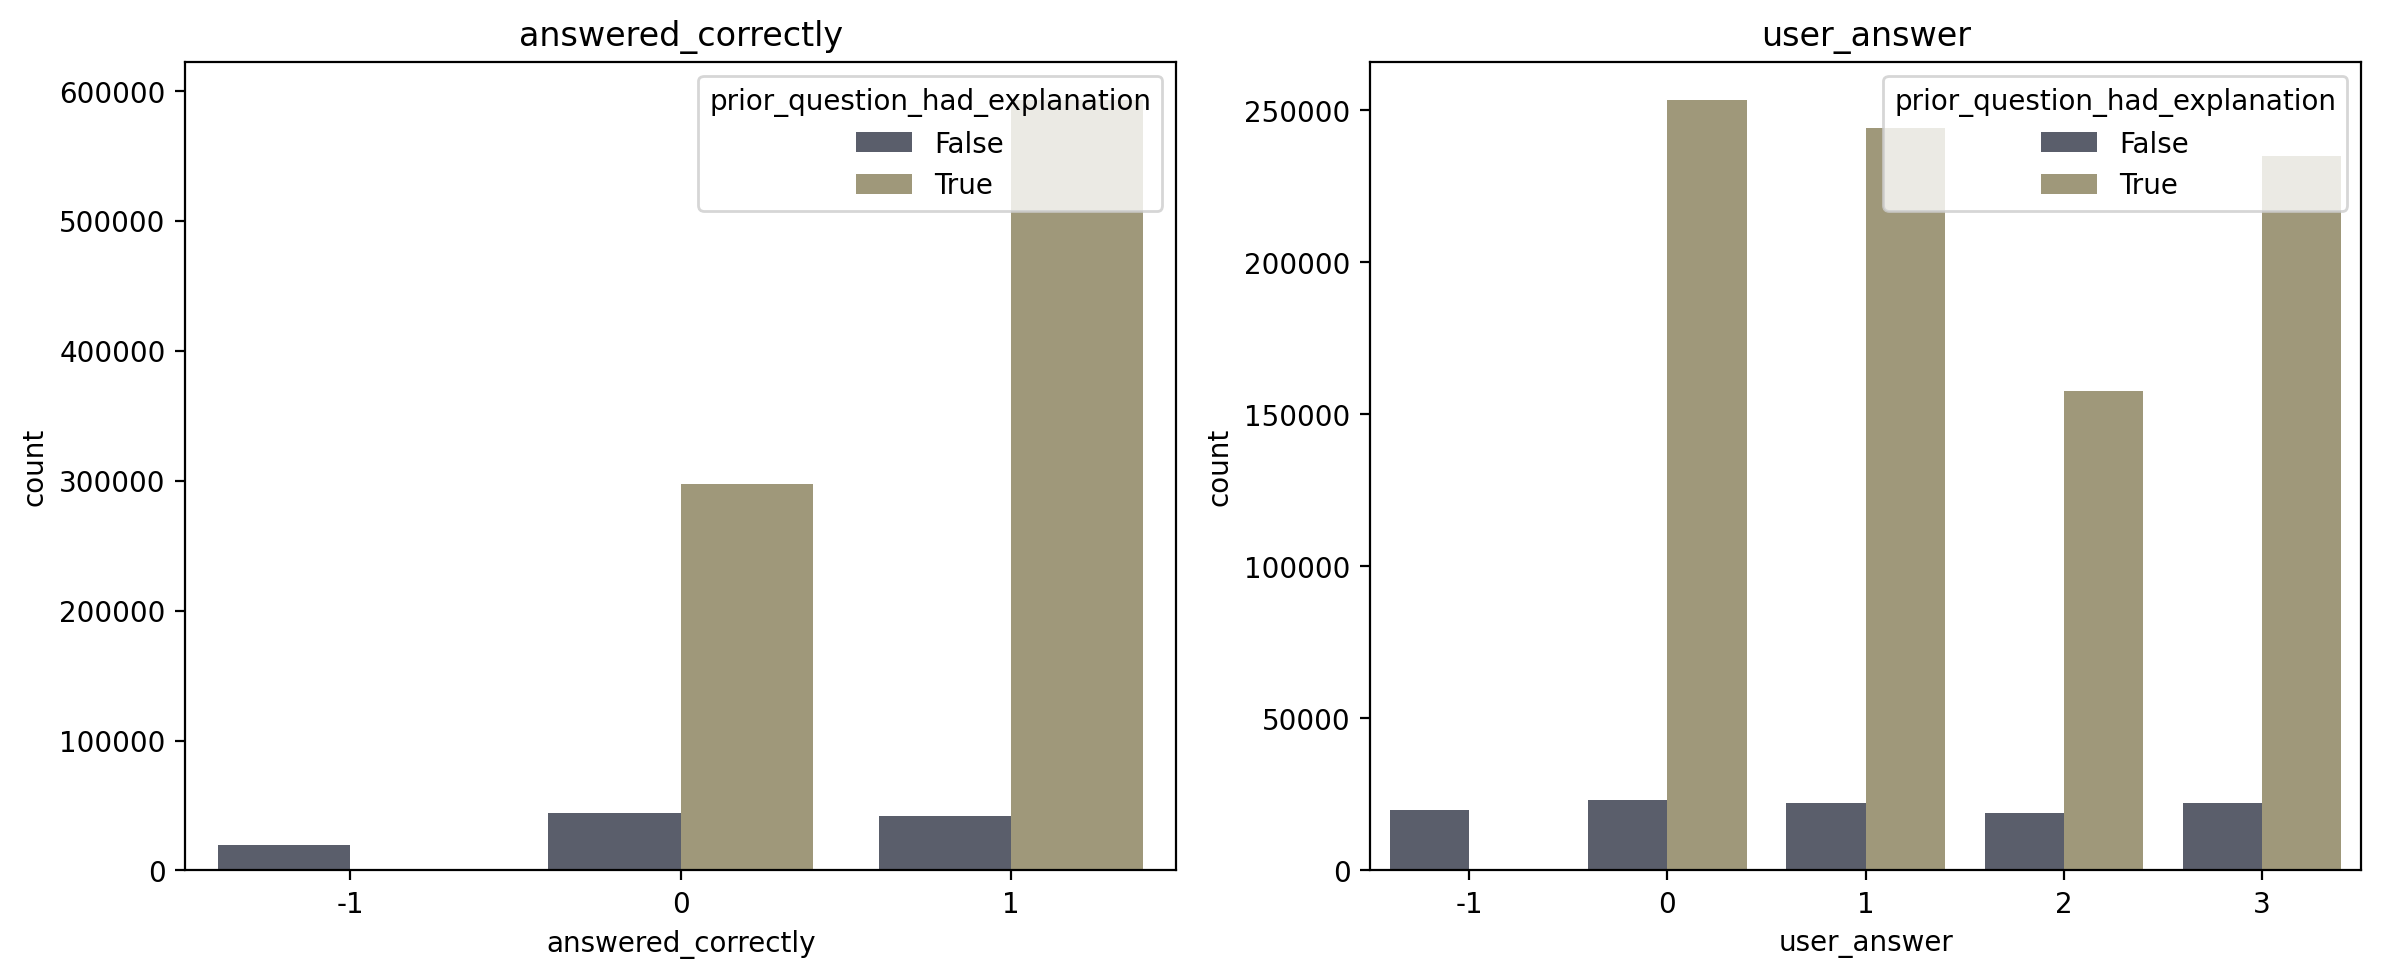

In [ ]:
ans_col = ['answered_correctly','user_answer']

total = len(train)
plt.figure(figsize=(12,5),dpi=100)

df = train[['answered_correctly','user_answer','prior_question_had_explanation']].dropna()

for i, col in enumerate(ans_col):
  plt.subplot(1,2,i+1)
  sns.countplot(df[col],palette='cividis',hue=df['prior_question_had_explanation'])
  plt.title(col)
  plt.tight_layout()

사용자 대다수는 이전 문제 번들에 답을 고른 후, 해답지?설명(explanation)을 본다.

### Correct Answers by users

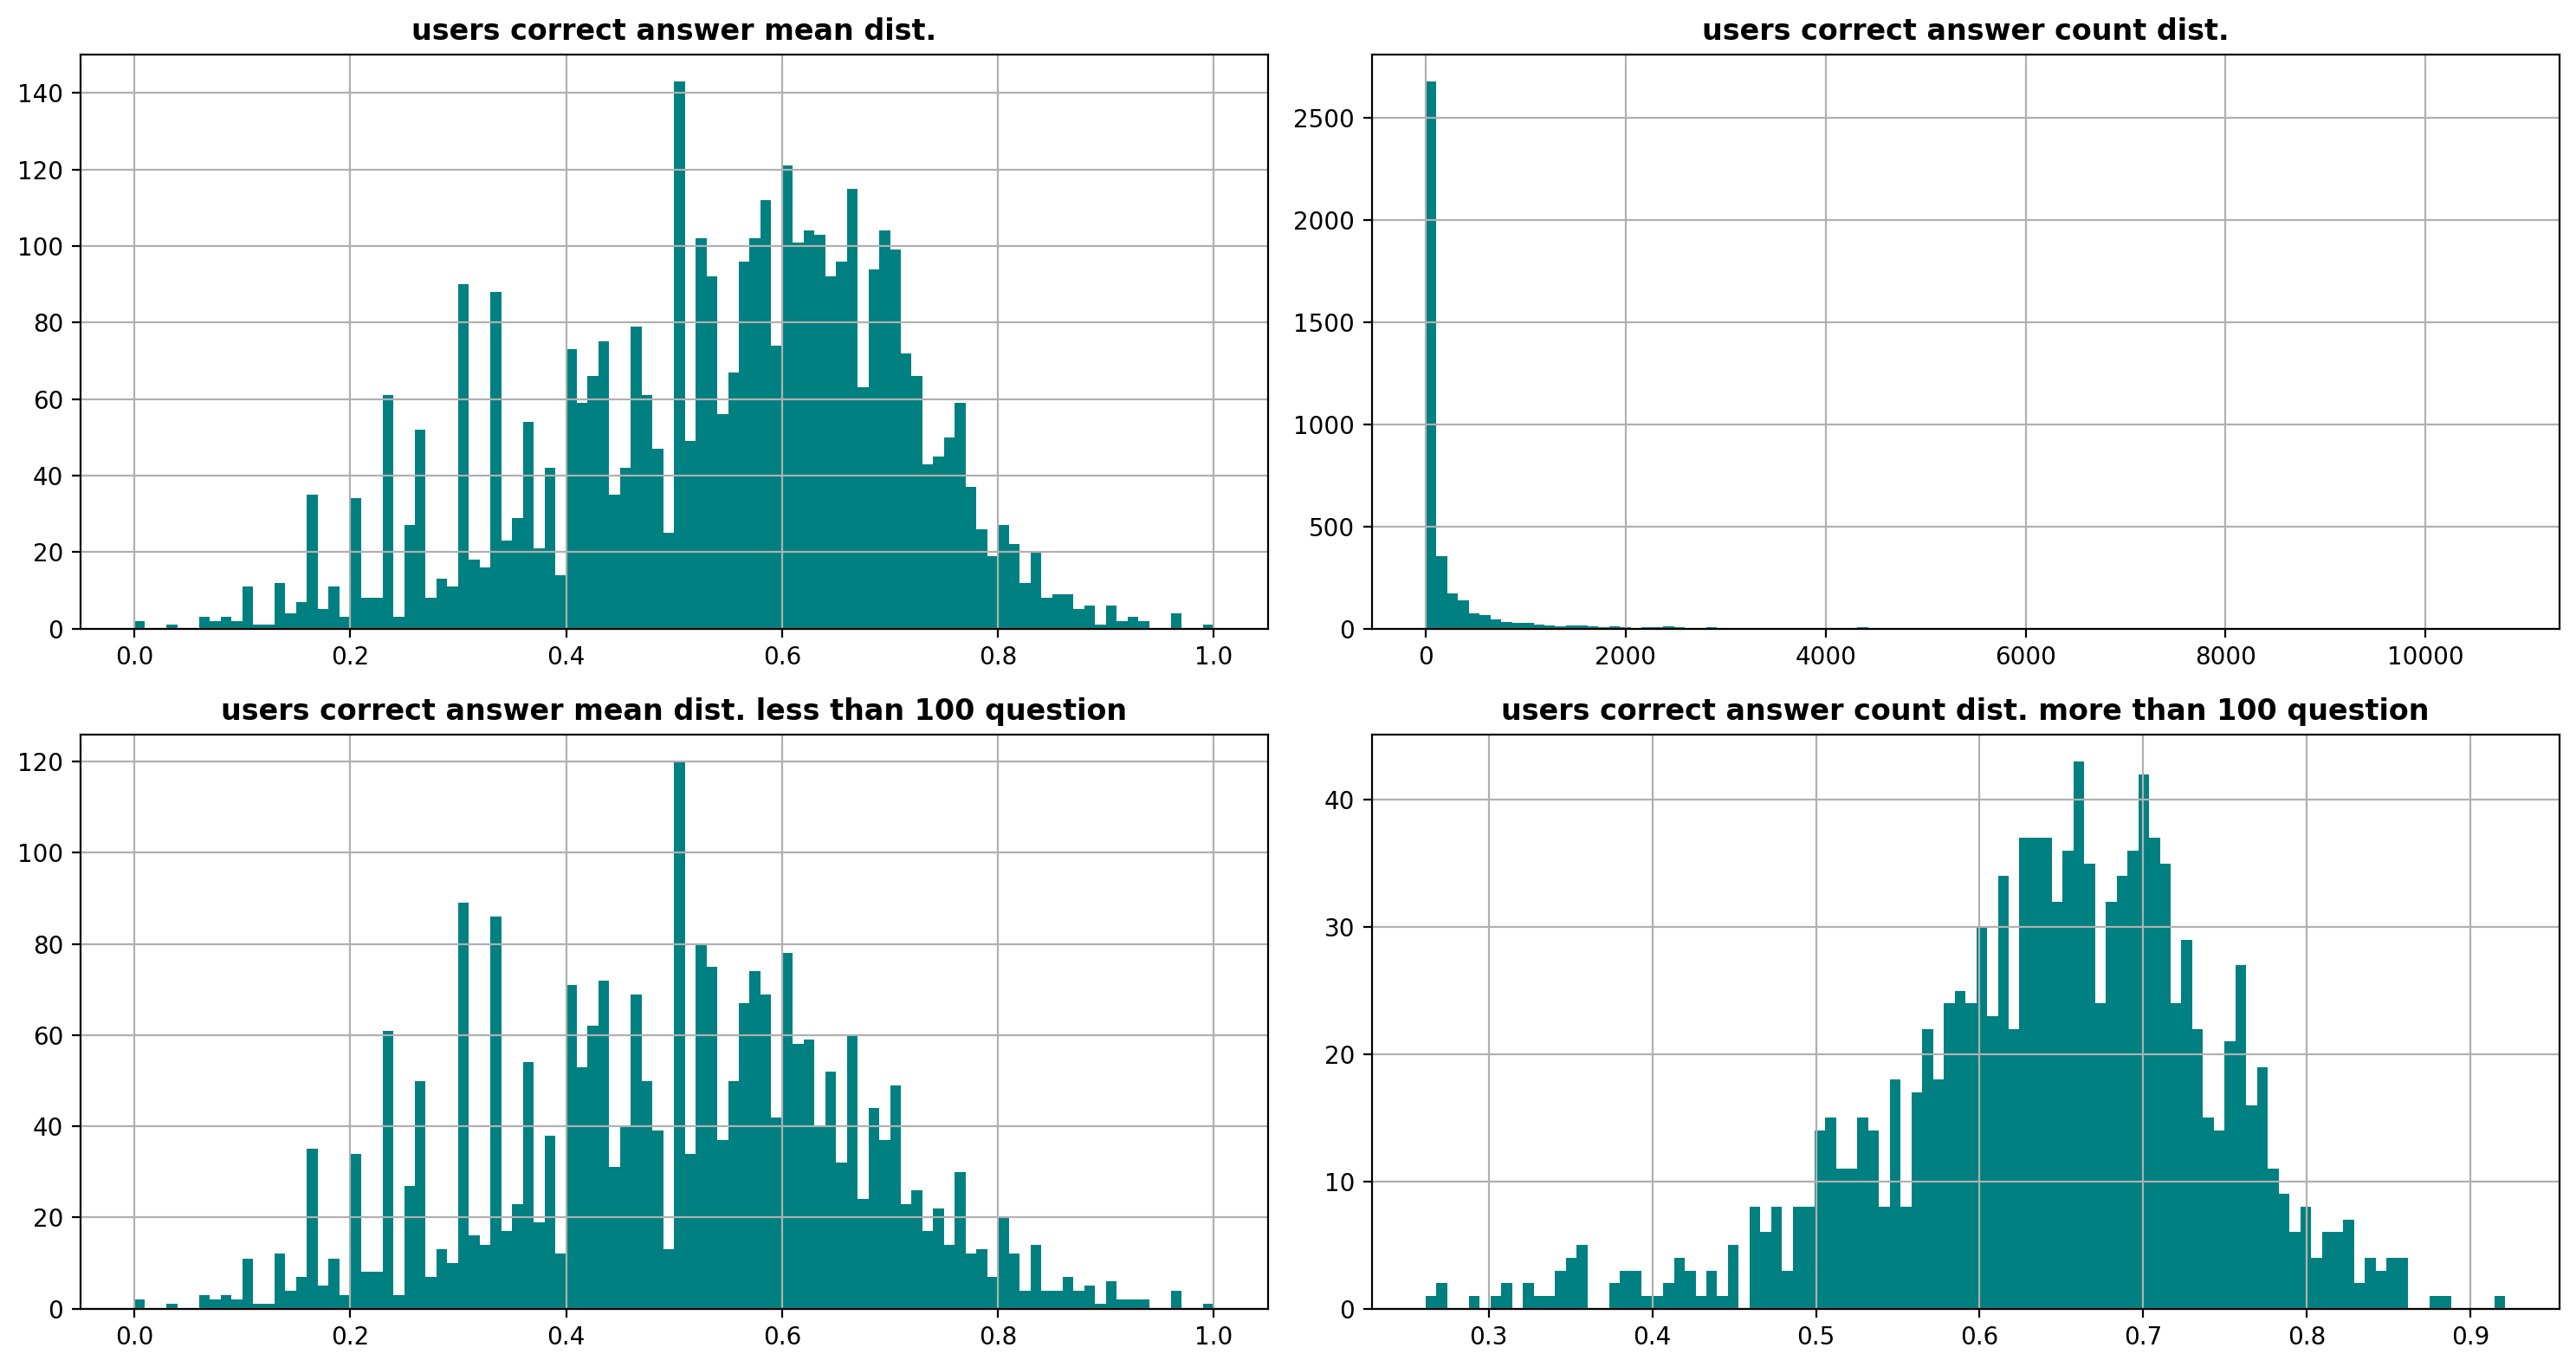

In [ ]:
train_only_df = train[train['answered_correctly']!=-1]
grouped_by_user_df = train_only_df.groupby('user_id')
user_answers_df = grouped_by_user_df.agg({'answered_correctly': ['mean', 'count', 'sum', 'std', 'median', 'skew']})

fig,ax=plt.subplots(figsize=(15,8), dpi=100)

plt.subplot(2, 2, 1)
g1=user_answers_df[('answered_correctly','mean')].hist(bins=100, color='teal')
g1.set_title("users correct answer mean dist.", fontweight='bold')

plt.subplot(2, 2, 2)
g2=user_answers_df[('answered_correctly','count')].hist(bins=100, color='teal')
g2.set_title('users correct answer count dist.', fontweight='bold')

plt.subplot(2, 2, 3)
g3=user_answers_df[user_answers_df[('answered_correctly','count')]<= 100][('answered_correctly','mean')].hist(bins=100, color='teal')
g3.set_title('users correct answer mean dist. less than 100 question', fontweight='bold')

plt.subplot(2, 2, 4)
g4=user_answers_df[user_answers_df[('answered_correctly','count')]>=100][('answered_correctly','mean')].hist(bins=100, color='teal')
g4.set_title('users correct answer count dist. more than 100 question', fontweight='bold')
plt.tight_layout()
plt.show()

평균 사용자 점수는 정답의 전체 백분율(왼쪽 아래 그래프)보다 낮다. 이것은 헤비유저들이 훨씬 더 좋은 점수를 가지고 있다는 것을 의미한다.

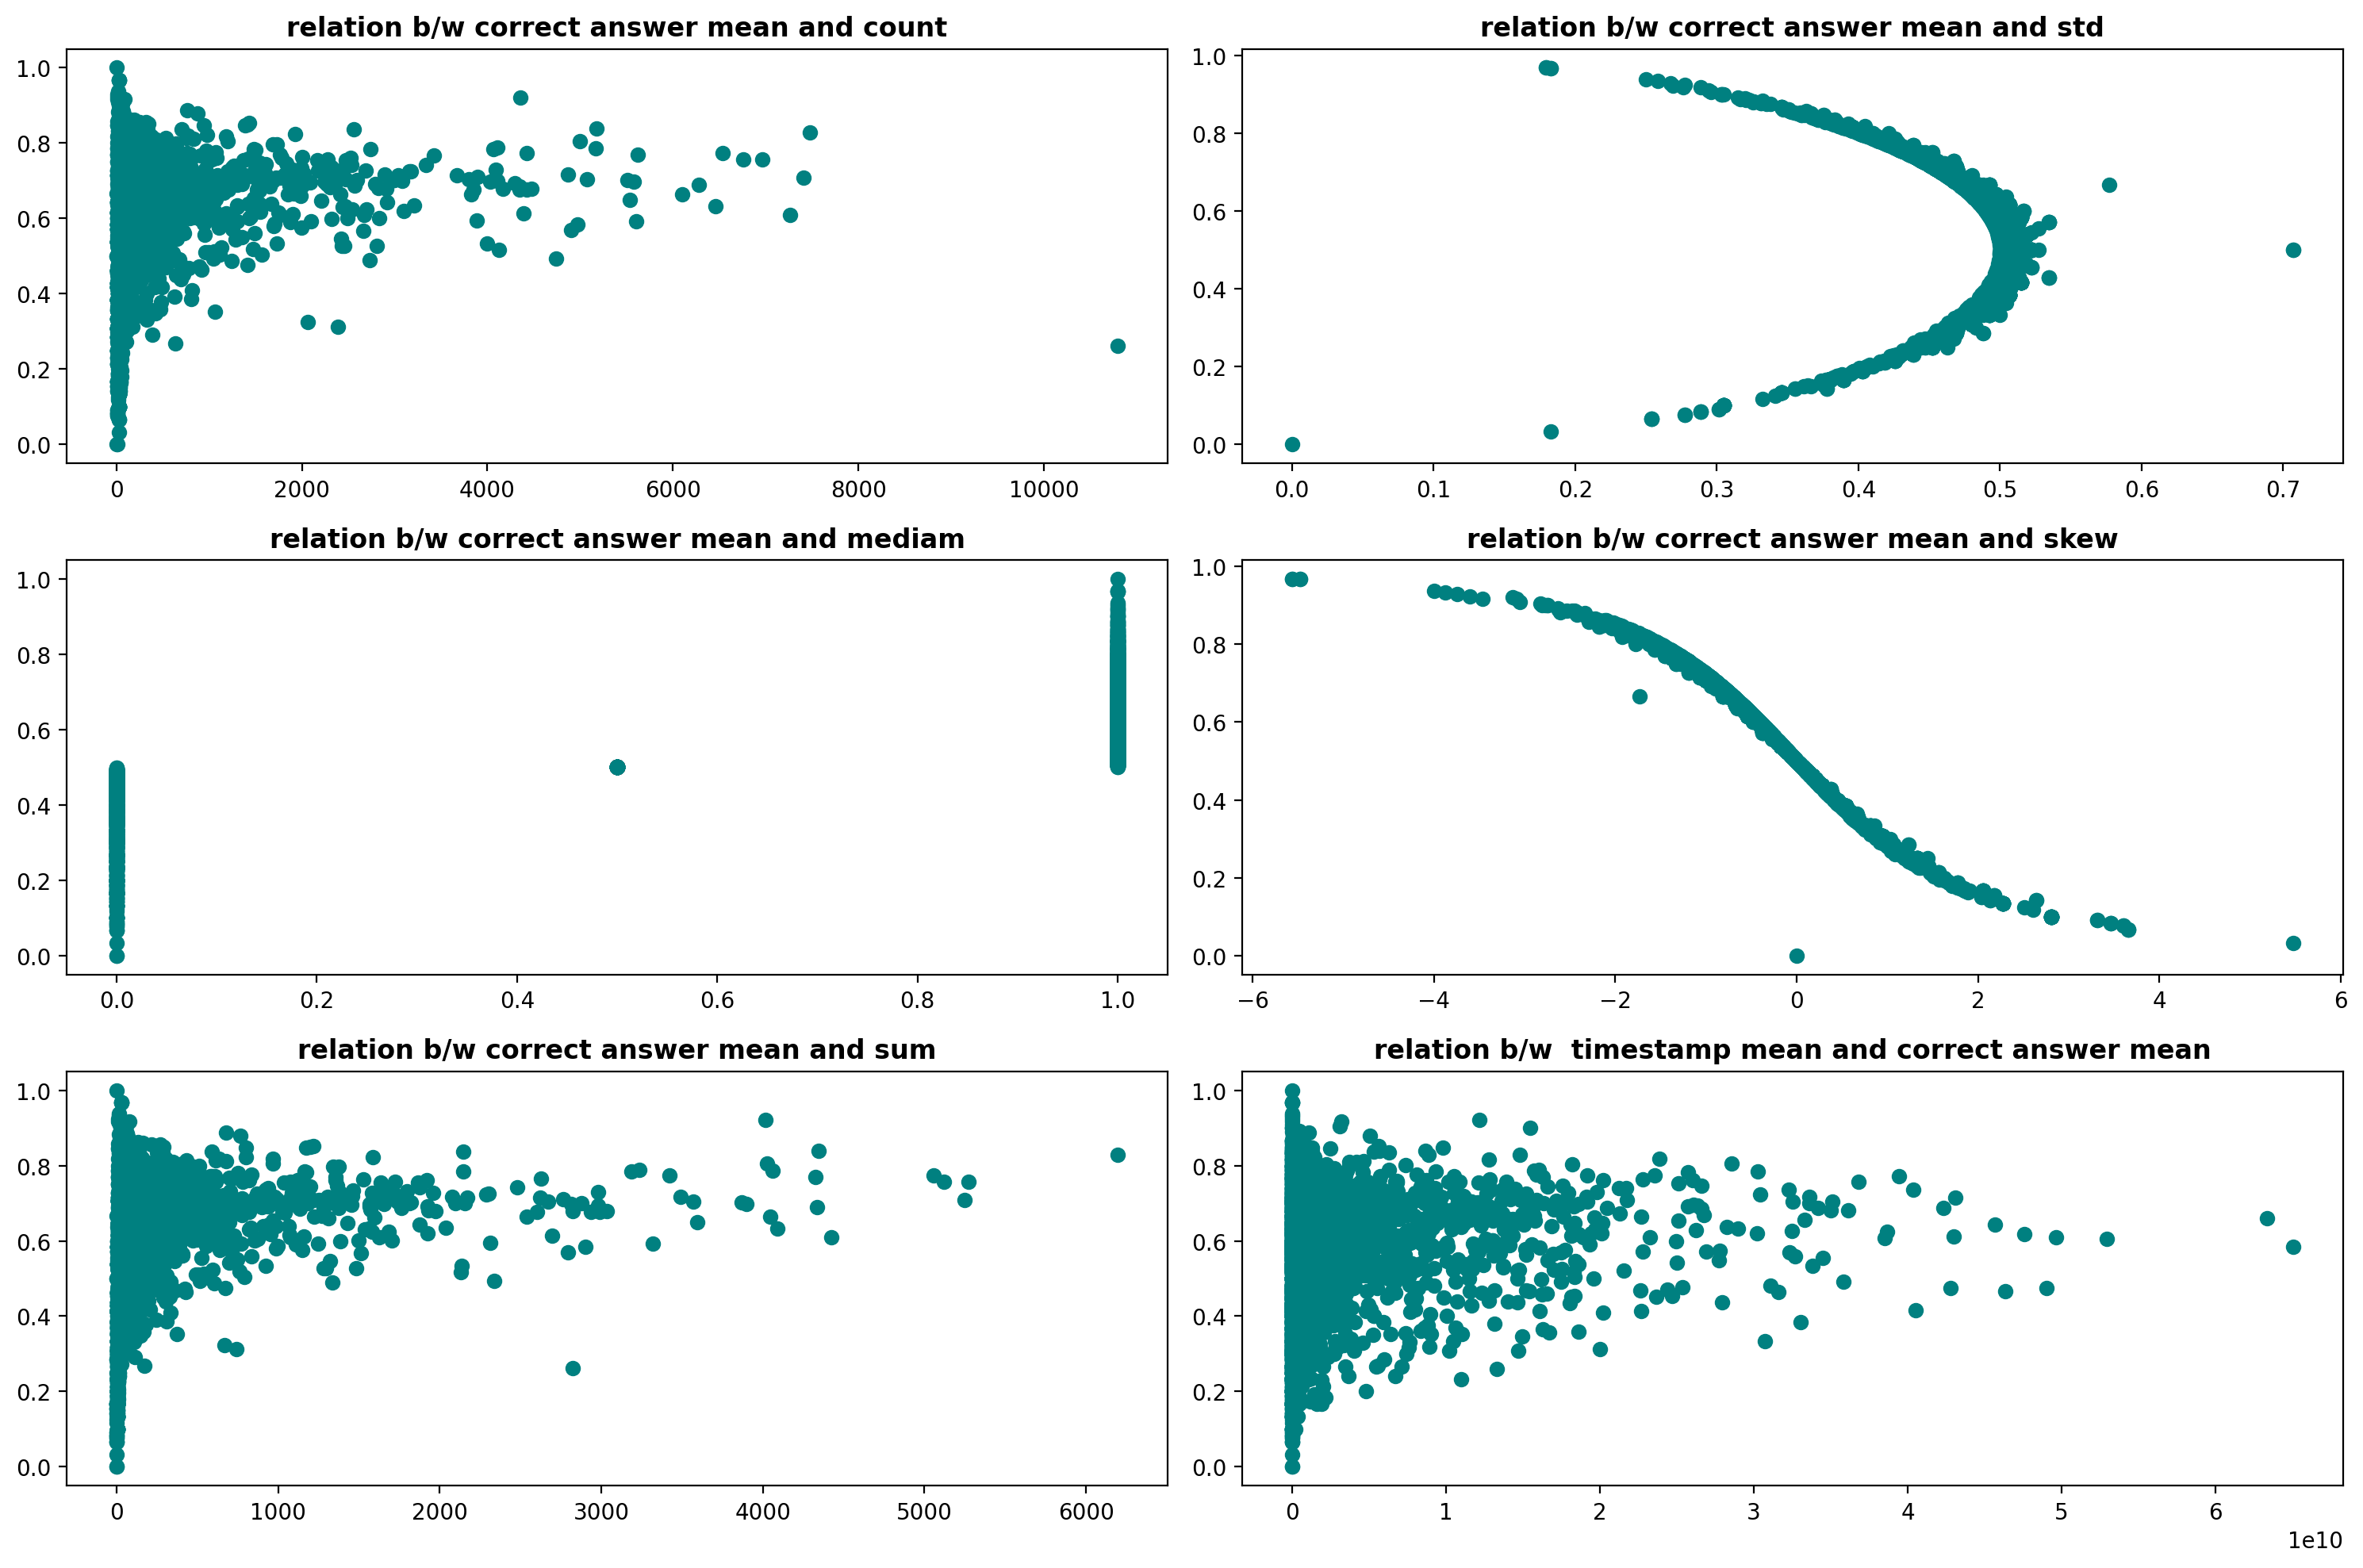

In [ ]:
user_time_answers_df = grouped_by_user_df.agg({'answered_correctly': ['mean', 'count'],
                                        'timestamp': ['mean', 'count']})

fig,ax=plt.subplots(figsize=(15,10), dpi=100)

plt.subplot(3, 2, 1)
plt.scatter(x = user_answers_df[('answered_correctly','count')], 
            y = user_answers_df[ ('answered_correctly','mean')], color='teal')
plt.title('relation b/w correct answer mean and count',fontweight='bold')

plt.subplot(3, 2, 2)
plt.scatter(x = user_answers_df[('answered_correctly','std')], 
            y = user_answers_df[ ('answered_correctly','mean')], color='teal')
plt.title('relation b/w correct answer mean and std',fontweight='bold')

plt.subplot(3, 2, 3)
plt.scatter(x = user_answers_df[('answered_correctly','median')], 
            y = user_answers_df[ ('answered_correctly','mean')], color='teal')
plt.title('relation b/w correct answer mean and mediam',fontweight='bold')

plt.subplot(3, 2, 4)
plt.scatter(x = user_answers_df[('answered_correctly','skew')], 
            y = user_answers_df[ ('answered_correctly','mean')], color='teal')
plt.title('relation b/w correct answer mean and skew',fontweight='bold')

plt.subplot(3, 2, 5)
plt.scatter(x = user_answers_df[('answered_correctly','sum')], 
            y = user_answers_df[ ('answered_correctly','mean')], color='teal')
plt.title('relation b/w correct answer mean and sum',fontweight='bold')

plt.subplot(3, 2, 6)
plt.scatter(x = user_time_answers_df[ ('timestamp','mean')], 
            y = user_time_answers_df[ ('answered_correctly','mean')], color='teal')
plt.title('relation b/w  timestamp mean and correct answer mean',fontweight='bold')
plt.tight_layout()
plt.show()

---
Q1. 'prior_question_elapsed_time' 변수에서  '첫 번째 문제 번들 또는 강의'에서는  null값이라고 하는데, 그러면 중간에 강의가 있는 경우는 이전 문제를 푼 시간을 어떻게 파악하지??


Q2 그러면 마지막 문제에 대한 소요 시간은 어떻게 파악하지?
- 생각해보니까 다음 문제가 있었음.